# Algorithm accuracy analysis

- In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk, we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in [their validation study](https://journals.sagepub.com/doi/abs/10.1177/0093854808326545).
- We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

## Setup

In [1]:
################# To use R in Jupyter Notebook ###############
import rpy2.ipython
%load_ext rpy2.ipython

################# To ignore warnings ##################
import warnings
warnings.filterwarnings('ignore')

################## To have multiple outputs ###################
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

from IPython.display import display

## Loading packages 

In [2]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
 tidyverse, # tidyverse packages 
 conflicted, # an alternative conflict resolution strategy 
 ggthemes, # for more themes 
 patchwork, # for arranging ggplots
 scales, # for rescales 
 survival, # for survival analysis
 ggfortify, # # data viz tools for statistical analysis
 grid, # for adding grids 
 gridExtra, # for grid graphics 
 broom, # for modeling
 reticulate, # Python enginge for R markdown
 purrr # for multiple models
)

# To avoid conflicts 
conflict_prefer("filter", "dplyr") 
conflict_prefer("select", "dplyr") 

R[write to console]: Loading required package: pacman

R[write to console]: [conflicted] Will prefer dplyr::filter over any other package

R[write to console]: [conflicted] Will prefer dplyr::select over any other package



## Loading data 

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

- N of observations (rows): 7,214
- N of variables (columns): 53

In [3]:
%%R

cox_data <- read_csv("/home/jae/compas-analysis/data/cox-parsed.csv")


R[write to console]: Parsed with column specification:
cols(
  .default = col_character(),
  id = col_double(),
  compas_screening_date = col_date(format = ""),
  dob = col_date(format = ""),
  age = col_double(),
  juv_fel_count = col_double(),
  decile_score = col_double(),
  juv_misd_count = col_double(),
  juv_other_count = col_double(),
  priors_count = col_double(),
  days_b_screening_arrest = col_double(),
  c_jail_in = col_datetime(format = ""),
  c_jail_out = col_datetime(format = ""),
  c_offense_date = col_date(format = ""),
  c_arrest_date = col_date(format = ""),
  c_days_from_compas = col_double(),
  is_recid = col_double(),
  r_days_from_arrest = col_double(),
  r_offense_date = col_date(format = ""),
  r_jail_in = col_date(format = ""),
  r_jail_out = col_date(format = "")
  # ... with 13 more columns
)

R[write to console]: See spec(...) for full column specifications.



## Wrangling data 

In [4]:
%%R

# Wrangling data  
df <- cox_data %>% 
    filter(score_text != "N/A") %>%
    filter(end > start) %>%
    mutate(c_charge_degree = factor(c_charge_degree),
           age_cat = factor(age_cat),
           race = factor(race, levels = c("Caucasian","African-American","Hispanic","Other","Asian","Native American")),
           sex = factor(sex, levels = c("Male","Female")),
           score_factor = factor(score_text, levels = c("Low", "Medium", "High")))

In [5]:
%%R

grp <- df[!duplicated(df$id),]

## Descriptive analysis

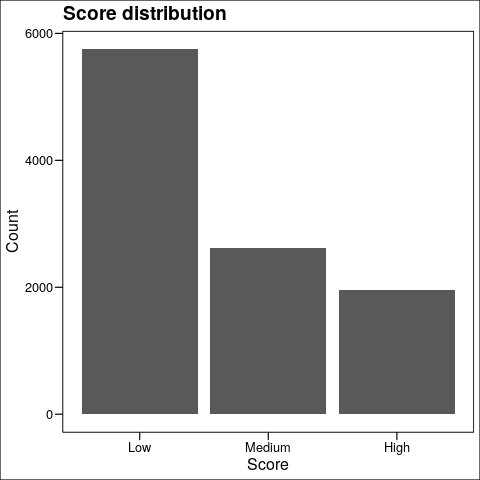

In [6]:
%%R

# Set theme 
theme_set(theme_base())

grp %>% 
    group_by(score_factor) %>%
      count() %>%
      ggplot(aes(x = score_factor, y = n)) +
        geom_col() +
        labs(x = "Score",
             y = "Count",
             title = "Score distribution")

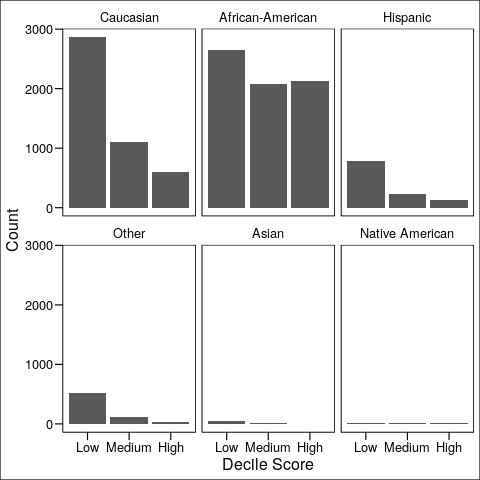

In [7]:
%%R

df %>%
  ggplot(aes(ordered(score_factor))) + 
          geom_bar() +
          facet_wrap(~race, nrow = 2) +
          labs(x = "Decile Score",
               y = "Count",
               Title = "Defendant's Decile Score")

## Modeling

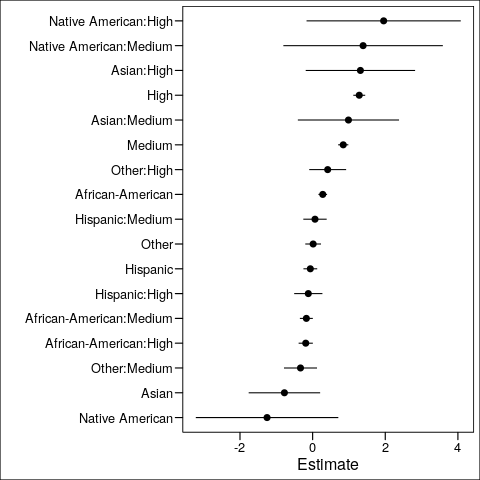

In [8]:
%%R

f2 <- Surv(start, end, event, type="counting") ~ race + score_factor + race * score_factor

model <- coxph(f2, data = df)

model %>%
  tidy(conf.inf = TRUE) %>%
  mutate(term = gsub("race|score_factor","", term)) %>% 
  filter(term != "<chr>") %>%
  ggplot(aes(x = fct_reorder(term, estimate), y = estimate, ymax = conf.high, ymin = conf.low)) +
  geom_pointrange() +
  coord_flip() +
  labs(y = "Estimate", x = "")


The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.


In [9]:
%%R

visualize_surv <- function(input){
f <- Surv(start, end, event, type="counting") ~ score_factor

fit <- survfit(f, data = input)

fit %>%
    tidy(conf.int = TRUE) %>%
    mutate(strata = gsub("score_factor=","", strata)) %>%
    mutate(strata = factor(strata, levels = c("High","Medium","Low"))) %>%
    ggplot(aes(x = time, y = estimate, ymax = conf.high, ymin = conf.low, group = strata, col = strata)) +
    geom_pointrange(alpha = 0.1) +
    guides(colour = guide_legend(override.aes = list(alpha = 1))) +
    ylim(c(0, 1)) +
    labs(x = "Time", y = "Estimated survival rate", col = "Strata")}

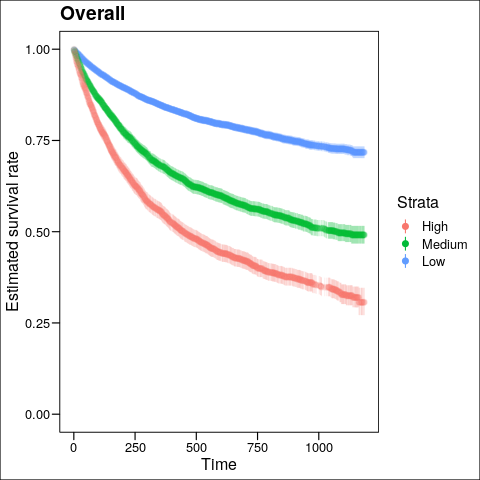

In [10]:
%%R

visualize_surv(df) + ggtitle("Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.


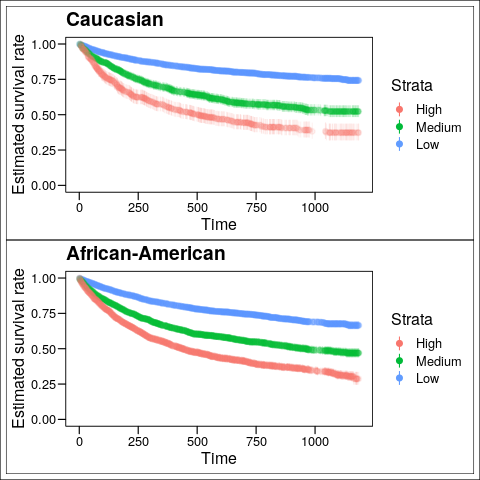

In [11]:
%%R

(df %>% filter(race == "Caucasian") %>% visualize_surv() + ggtitle("Caucasian")) /
(df %>% filter(race == "African-American") %>% visualize_surv() + ggtitle("African-American")) 


In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

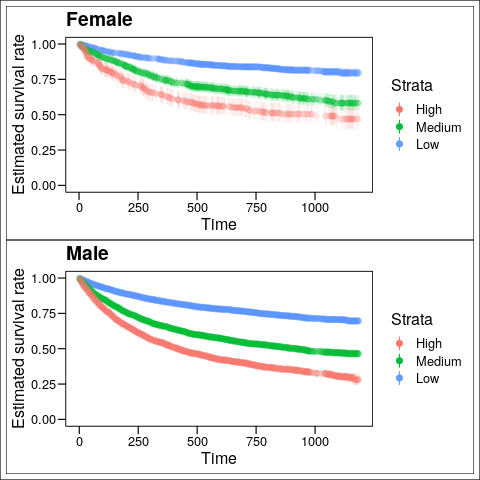

In [12]:
%%R

(df %>% filter(sex == "Female") %>% visualize_surv() + ggtitle("Female")) /
(df %>% filter(sex == "Male") %>% visualize_surv() + ggtitle("Male"))

As these plots show, the COMPAS score treats a High risk women the same as a Medium risk man.

## Risk of Recidivism Accuracy

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.


In [13]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("/home/jae/bias-in-ml/compas/data/cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))

recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))

rset = set(recid)

surv = [i for i in pop if i not in rset]

Define a function for a bar plot.

In [14]:
import matplotlib.pyplot as plt

def bar_plot(x, y):
    t = table(list(x), list(y))

    plt.bar(range(len(t)), list(t.values()), align='center') # Create a bar graph 
    plt.xticks(range(len(t)), list(t.keys())) # Create xlabel names 

Text(0.5, 1.0, 'All defendants')

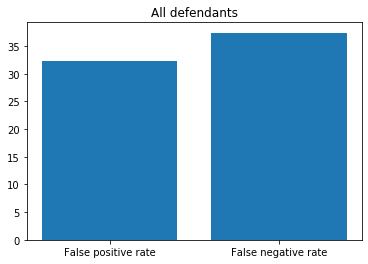

In [15]:
bar_plot(recid, surv)
plt.title("All defendants")
plt.show()

- That number is higher for African Americans at 44.85% and lower for whites at 23.45%.

Text(0.5, 1.0, 'Black defendants')

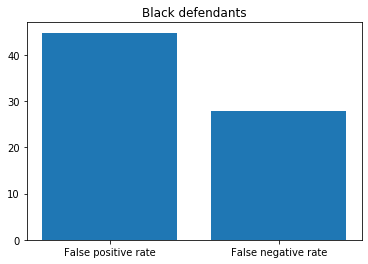

Text(0.5, 1.0, 'White defendants')

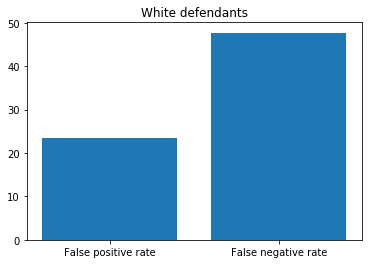

In [16]:

is_afam = is_race("African-American")

bar_plot(filter(is_afam, recid), filter(is_afam, surv))
plt.title("Black defendants")
plt.show()

is_white = is_race("Caucasian")

bar_plot(filter(is_white, recid), filter(is_white, surv))
plt.title("White defendants")
plt.show()

## Risk of Violent Recidivism 

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [17]:
vpeople = []
with open("/home/jae/compas-analysis/data/cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

Text(0.5, 1.0, 'All defendants')

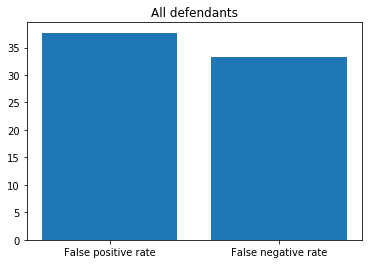

In [18]:

bar_plot(vrecid, vsurv)
plt.title("All defendants")
plt.show()


Even more so for Black defendants.

Text(0.5, 1.0, 'Black defendants')

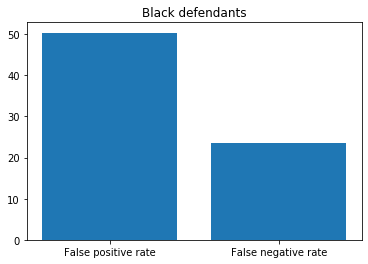

Text(0.5, 1.0, 'White defendants')

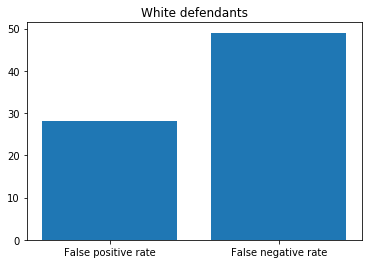

In [19]:
is_afam = is_race("African-American")

bar_plot(filter(is_afam, vrecid), filter(is_afam, vsurv))
plt.title("Black defendants")
plt.show()

is_white = is_race("Caucasian")

bar_plot(filter(is_white, vrecid), filter(is_white, vsurv))
plt.title("White defendants")
plt.show()
